In [1]:
import sys
import scipy.io
import numpy as np
from numpy.linalg import det
import matplotlib.pyplot as plt
import imageio
import os
import glob
%matplotlib inline

In [2]:
def I_XY(X,Y):
    
    dim_X = X.ndim
    dim_Y = Y.ndim
    
    cov = np.cov(X,Y)
    if (dim_X == 1):
        det_sigma_X = cov[0,0]
    elif (dim_X > 1):
        det_sigma_X = np.linalg.det(cov[:dim_X,:dim_X])
    if (dim_Y == 1):
        det_sigma_Y = cov[dim_X,dim_X]
    elif (dim_Y > 1):
        det_sigma_Y = np.linalg.det(cov[dim_X:,dim_X:])
        
    I = np.log2((det_sigma_X*det_sigma_Y)/np.linalg.det(cov))
    
    return I

def I_XYZ(X,Y,Z):
    
    dim_X = X.ndim
    dim_Y = Y.ndim
    dim_Z = Z.ndim
    
    cov = np.cov(np.vstack((X,Y,Z)))
    if (dim_X == 1):
        det_sigma_X = cov[0,0]
    elif (dim_X > 1):
        det_sigma_X = np.linalg.det(cov[:dim_X,:dim_X])
    det_sigma_YZ = np.linalg.det(cov[dim_X:,dim_X:])
        
    I = np.log2((det_sigma_X*det_sigma_YZ)/np.linalg.det(cov))
    
    return I

def PID(X,Y,Z):
    I_xy = I_XY(X,Y)
    I_xz = I_XY(X,Z)
    I_xyz = I_XYZ(X,Y,Z)
    
    R = min(I_xy,I_xz)
    
    if R == I_xy:
        Uy = 0
        Uz = I_xz - I_xy
        S = I_xyz - I_xz   
    else:
        Uz = 0
        Uy = I_xy - I_xz
        S = I_xyz - I_xy
    return Uy, Uz, S, R

def transfer_entropy(U_mat, S_mat):
    T_YX = np.zeros((len(S_mat),len(S_mat)))
    for i in range(len(S_mat)):
        for j in range(len(S_mat)):
            if U_mat[i,j] < 0:
                T_YX[i,j] = -U_mat[i,j] + S_mat[i,j]
            else:
                T_YX[i,j] = S_mat[i,j]
    return(T_YX)

## Real TS analysis

In [3]:
data = scipy.io.loadmat("102715.REST1.RL.GLS.ptseries.mat")
keys = data.keys()
print(keys)

dict_keys(['__header__', '__version__', '__globals__', 'tseries'])


In [4]:
X = data['tseries']
print(np.shape(X))

(343, 1200)


### Normal PID

In [5]:
def SRU(X):    
    X_prev = X[:,:-1]
    X_succ = X[:,1:]
    S_mat = np.zeros((len(X),len(X)))
    R_mat = np.zeros((len(X),len(X)))
    U_mat = np.zeros((len(X),len(X)))

    for i in range(len(X)):
        for j in range(len(X)):
            if i != j:
                Uy, Uz, S, R = PID(X_succ[i,:],X_prev[i,:],X_prev[j,:])
                S_mat[i,j] = S
                R_mat[i,j] = R
                if (Uy > Uz):
                    U_mat[i,j] = Uy
                else:
                    U_mat[i,j] = -Uz
    return(S_mat, R_mat, U_mat)

In [10]:
S_mat, R_mat, U_mat = SRU(X)

Text(0.5, 1.0, 'Synergistic')

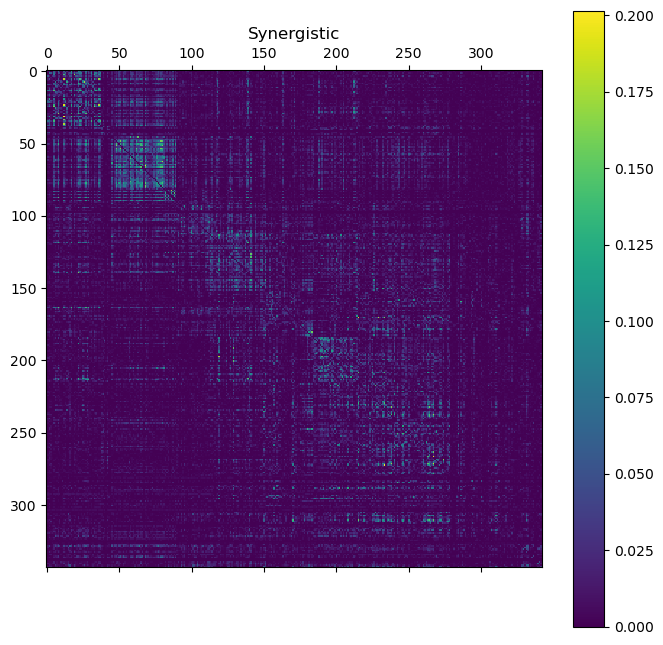

In [41]:
fig, ax = plt.subplots(figsize=(8,8))

cax = ax.matshow(S_mat)#, cmap='afmhot')
fig.colorbar(cax)
ax.set_title("Synergistic")

Text(0.5, 1.0, 'Redundant')

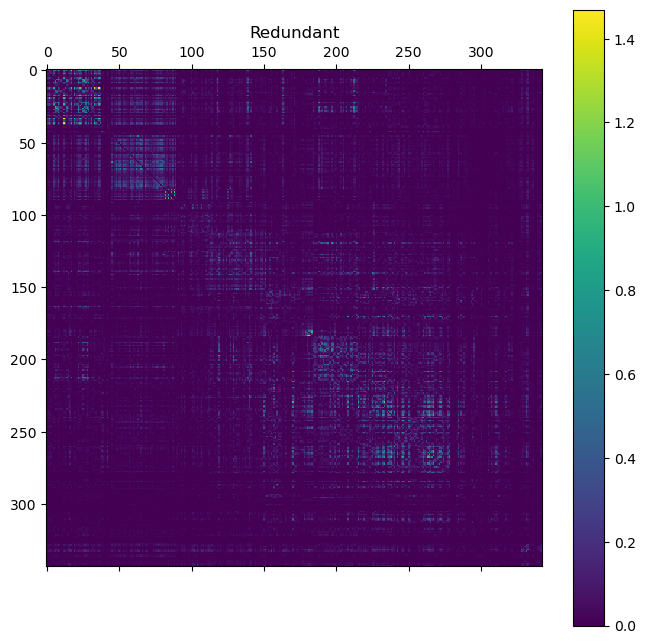

In [42]:
fig, ax = plt.subplots(figsize=(8,8))

cax = ax.matshow(R_mat)#, cmap='afmhot')
fig.colorbar(cax)
ax.set_title("Redundant")

Text(0.5, 1.0, 'Unique')

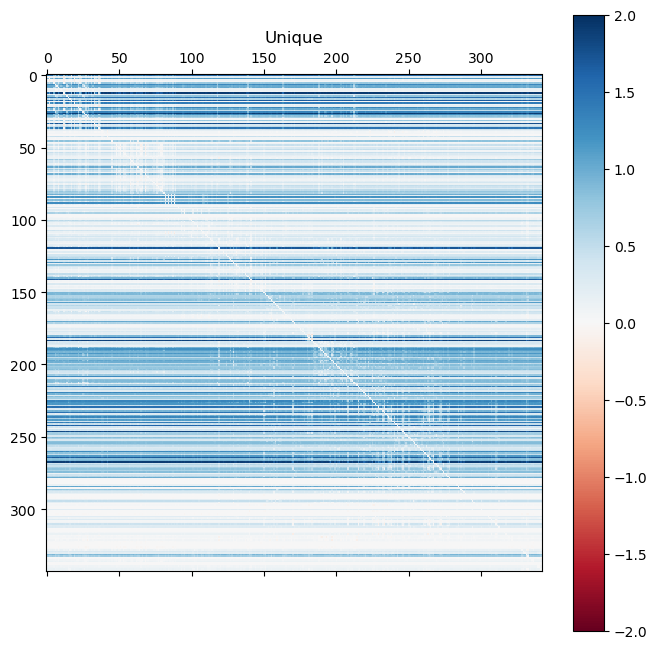

In [43]:
fig, ax = plt.subplots(figsize=(8,8))

cax = ax.matshow(U_mat, cmap='RdBu', vmin = -2, vmax = 2)
fig.colorbar(cax)
ax.set_title("Unique")

Text(0.5, 1.0, 'WMS')

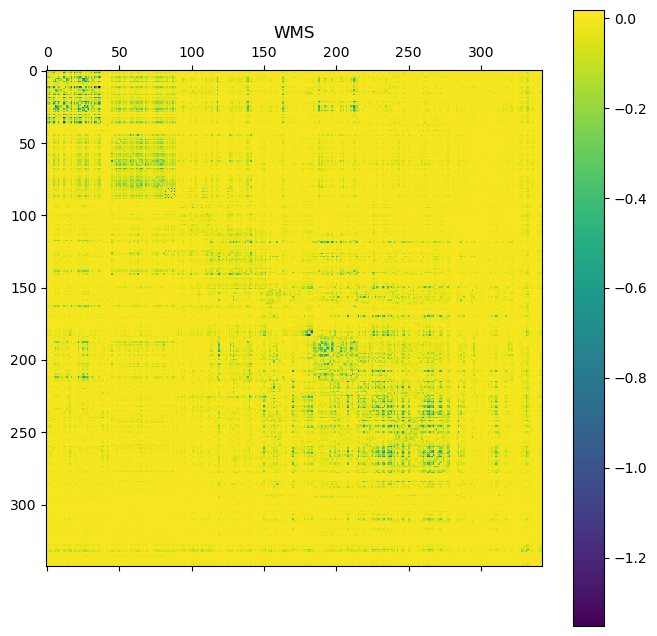

In [15]:
fig, ax = plt.subplots(figsize=(8,8))

cax = ax.matshow(S_mat - R_mat)#, cmap='afmhot')
fig.colorbar(cax)
ax.set_title("WMS")

In [45]:
T_YX = transfer_entropy(U_mat,S_mat)

Text(0.5, 1.0, 'Transfer Entropy')

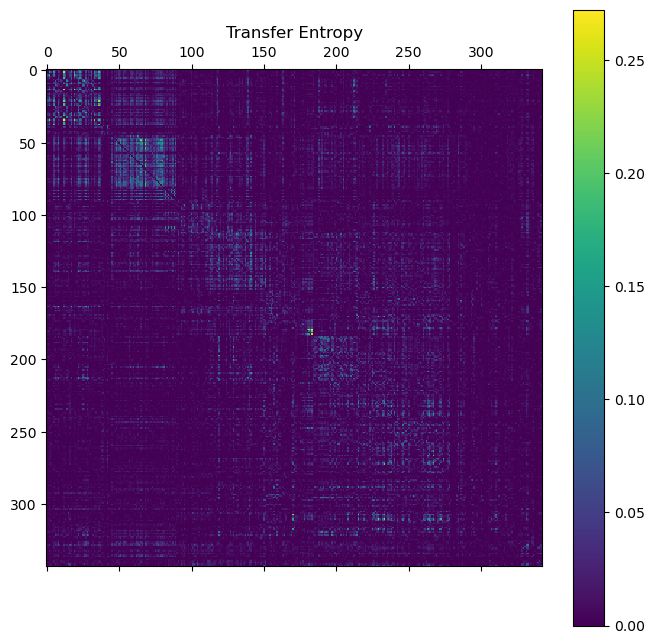

In [46]:
fig, ax = plt.subplots(figsize=(8,8))

cax = ax.matshow(T_YX)#, cmap='afmhot')
fig.colorbar(cax)
ax.set_title("Transfer Entropy")

### Mediano analysis

In [6]:
def SRU_mediano(X):    
    X_prev = X[:,:-1]
    X_succ = X[:,1:]
    S_mat = np.zeros((len(X),len(X)))
    R_mat = np.zeros((len(X),len(X)))
    U_mat = np.zeros((len(X),len(X)))

    for i in range(len(X)):
        for j in range(i):
            if i != j:
                X_12 = np.vstack((X_succ[i,:],X_succ[j,:]))
                Uy, Uz, S, R = PID(X_12,X_prev[i,:],X_prev[j,:])
                S_mat[i,j] = S
                R_mat[i,j] = R
                if (Uy > Uz):
                    U_mat[i,j] = Uy
                else:
                    U_mat[i,j] = -Uz
                    
    S_mat += S_mat.T
    R_mat += R_mat.T
    U_mat -= U_mat.T
    
    return(S_mat, R_mat, U_mat)

In [7]:
import time
t0 = time.time()
S_mm, R_mm, U_mm = SRU_mediano(X)
print(time.time() - t0)

149.23197531700134


Text(0.5, 1.0, 'Synergistic')

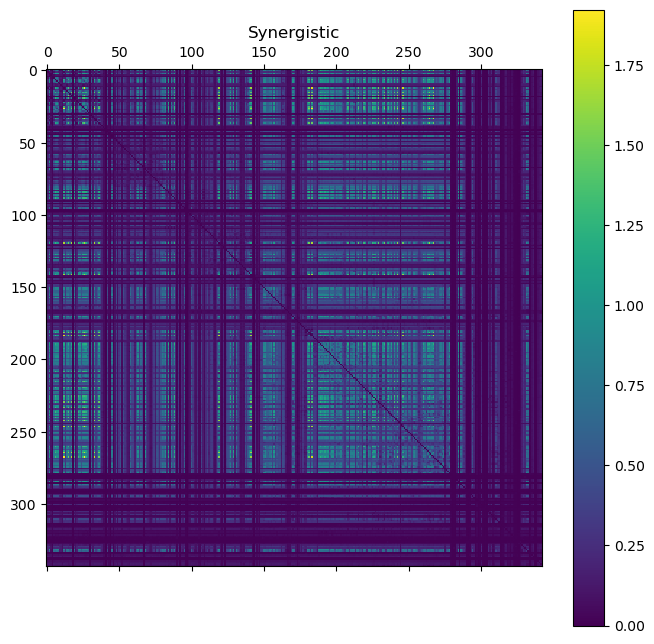

In [8]:
fig, ax = plt.subplots(figsize=(8,8))

cax = ax.matshow(S_mm)#, cmap='BuPu')
fig.colorbar(cax)
ax.set_title("Synergistic")

Text(0.5, 1.0, 'Redundant')

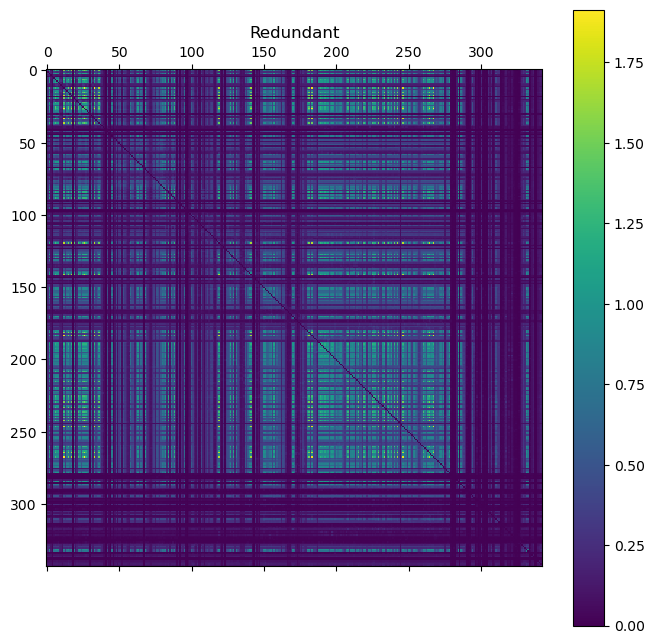

In [9]:
fig, ax = plt.subplots(figsize=(8,8))

cax = ax.matshow(R_mm)#, cmap='afmhot')
fig.colorbar(cax)
ax.set_title("Redundant")

Text(0.5, 1.0, 'Unique')

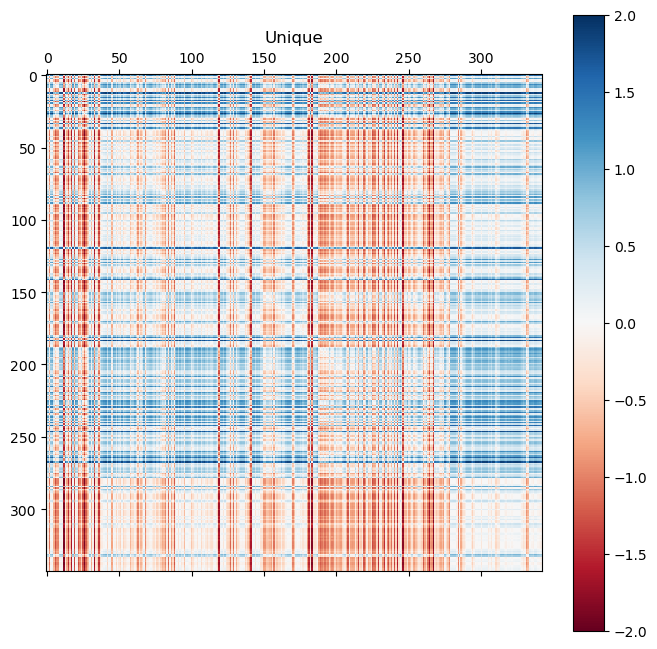

In [10]:
fig, ax = plt.subplots(figsize=(8,8))

cax = ax.matshow(U_mm, cmap='RdBu', vmin = -2, vmax = 2)
fig.colorbar(cax)
ax.set_title("Unique")

Text(0.5, 1.0, 'WMS')

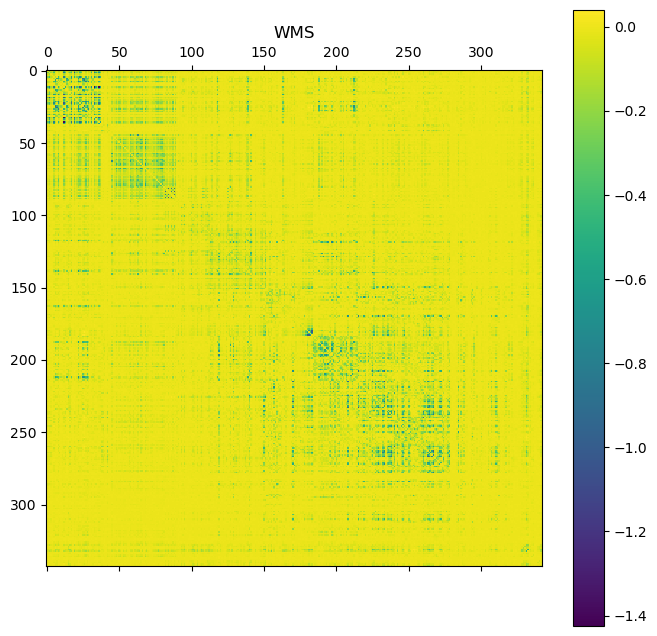

In [11]:
fig, ax = plt.subplots(figsize=(8,8))

cax = ax.matshow(S_mm - R_mm)#, cmap='afmhot')
fig.colorbar(cax)
ax.set_title("WMS")

In [12]:
T_YX = transfer_entropy(U_mm,S_mm)

Text(0.5, 1.0, 'Transfer Entropy')

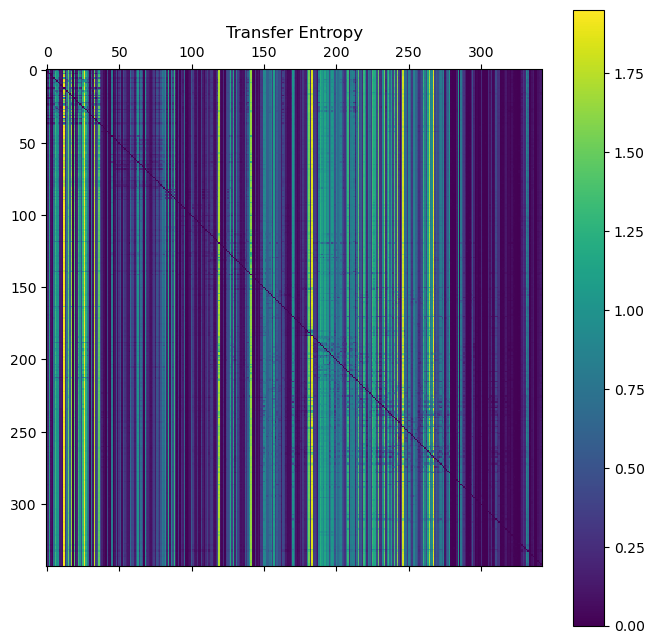

In [13]:
fig, ax = plt.subplots(figsize=(8,8))

cax = ax.matshow(T_YX)#, cmap='afmhot')
fig.colorbar(cax)
ax.set_title("Transfer Entropy")

### Different time delay

In [5]:
def SRU_delay(X,d):    
    X_prev = X[:,:-d]
    X_succ = X[:,d:]
    S_mat = np.zeros((len(X),len(X)))
    R_mat = np.zeros((len(X),len(X)))
    U_mat = np.zeros((len(X),len(X)))

    for i in range(len(X)):
        for j in range(i):
            if i != j:
                X_12 = np.vstack((X_succ[i,:],X_succ[j,:]))
                Uy, Uz, S, R = PID(X_12,X_prev[i,:],X_prev[j,:])
                S_mat[i,j] = S
                R_mat[i,j] = R
                if (Uy > Uz):
                    U_mat[i,j] = Uy
                else:
                    U_mat[i,j] = -Uz
                    
    S_mat += S_mat.T
    R_mat += R_mat.T
    U_mat -= U_mat.T
    
    return(S_mat, R_mat, U_mat)

In [6]:
def create_frame(t,M,name,title=None):
    fig, ax = plt.subplots(figsize=(8,8))
    if name == "u":
        cax = ax.matshow(M, cmap='RdBu', vmin = -2, vmax = 2)
    else:
        cax = ax.matshow(M, vmin = 0, vmax = 2)
    fig.colorbar(cax)
    ax.set_title(f"{title} t = {t}")
    plt.savefig(f'img_{t}_{name}.png', 
                transparent = False,  
                facecolor = 'white'
               )
    plt.close()
    
for t in range(1,11):
    s, r, u = SRU_delay(X,t)
    create_frame(t,s,"s",title="Synergistic")
    create_frame(t,r,"r",title="Redundant")
    create_frame(t,u,"u",title="Unique")
    
frames_s = []
frames_r = []
frames_u = []
for t in range(1,11):
    image = imageio.v2.imread(f'img_{t}_s.png')
    frames_s.append(image)
    image = imageio.v2.imread(f'img_{t}_r.png')
    frames_r.append(image)
    image = imageio.v2.imread(f'img_{t}_u.png')
    frames_u.append(image)

In [7]:
imageio.mimsave('S_ev.gif', # output gif
                frames_s,          # array of input frames
                fps = 2)
imageio.mimsave('R_ev.gif', # output gif
                frames_r,          # array of input frames
                fps = 2)
imageio.mimsave('U_ev.gif', # output gif
                frames_u,          # array of input frames
                fps = 2)

In [8]:
for filename in glob.glob("img_*"):
    os.remove(filename)